In [16]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

In [17]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['simple', 'new layers']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(8), range(8))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    res_incorrect = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

In [18]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Settings

In [19]:
log_and_model_path = 'd:/vcpi/dl04/'
data_path = 'd:/vcpi/gtsrb'

## Load balanced dataset

In this example we have created a dataset with 10000 samples per class. Each new sample was generated based on geometric and colour operations performed on the images of the original training dataset.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_listset = tf.data.Dataset.list_files(f'{data_path}/train_balanced_10000/*/*.png')
train_set = train_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

val_listset = tf.data.Dataset.list_files(f'{data_path}/val/*/*.png')
val_set = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_listset = tf.data.Dataset.list_files(f'{data_path}/test/*/*.png')
test_set = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [21]:
for image, label in train_set.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

dataset_length = train_set.cardinality().numpy()
print(dataset_length)


Image shape:  (32, 32, 3)
Label:  [False False False False False False False  True]
80000


In [22]:
train_set = train_set.cache()
train_set = train_set.shuffle(buffer_size=10200)
train_set = train_set.batch(batch_size = BATCH_SIZE)
train_set = train_set.prefetch(buffer_size = AUTOTUNE)

val_set = val_set.cache()
val_set = val_set.batch(batch_size = BATCH_SIZE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)

In [23]:
test_set = test_set.batch(batch_size = BATCH_SIZE)

## Model

This model is similar to the one used in the previous lesson

In [24]:
def model_III(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(128, (5, 5), 
                     input_shape=(imgSize, imgSize, channels)
                     ))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(128, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

In [25]:
modelV3 = model_III(8, 32, 3)

print(modelV3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       9728      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       409728    
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 128)      

## Prepare and train the model

In [26]:
def prepareCallbacks(path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack]



In [27]:
file_pathV4, callbacksV4 = prepareCallbacks('V4')

historyV4 = modelV3.fit(train_set,
          epochs=50, 
          validation_data = val_set, 
          callbacks=callbacksV4)

Epoch 1/50
2496/2500 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.9159
Epoch 1: val_accuracy improved from -inf to 0.90698, saving model to d:/vcpi/dl04//V4\cp.ckpt
2500/2500 [==============================] - 21s 7ms/step - loss: 0.2543 - accuracy: 0.9160 - val_loss: 0.2905 - val_accuracy: 0.9070
Epoch 2/50
2499/2500 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9899
Epoch 2: val_accuracy improved from 0.90698 to 0.91822, saving model to d:/vcpi/dl04//V4\cp.ckpt
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.2134 - val_accuracy: 0.9182
Epoch 3/50
2496/2500 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9936
Epoch 3: val_accuracy improved from 0.91822 to 0.92093, saving model to d:/vcpi/dl04//V4\cp.ckpt
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.2587 - val_accuracy: 0.9209
Epoch 4/50
2494/

## Evaluate

In [28]:
modelV3.load_weights(file_pathV4)

evalV3 = modelV3.evaluate(test_set, verbose=2)
print(evalV3)
valV3 = modelV3.evaluate(val_set, verbose=2)

131/131 - 1s - loss: 0.0490 - accuracy: 0.9894 - 583ms/epoch - 4ms/step
[0.049025535583496094, 0.9894484281539917]
81/81 - 0s - loss: 0.0821 - accuracy: 0.9771 - 229ms/epoch - 3ms/step


As can be seen by the results presented above for the test dataset, accuracy has been improved.

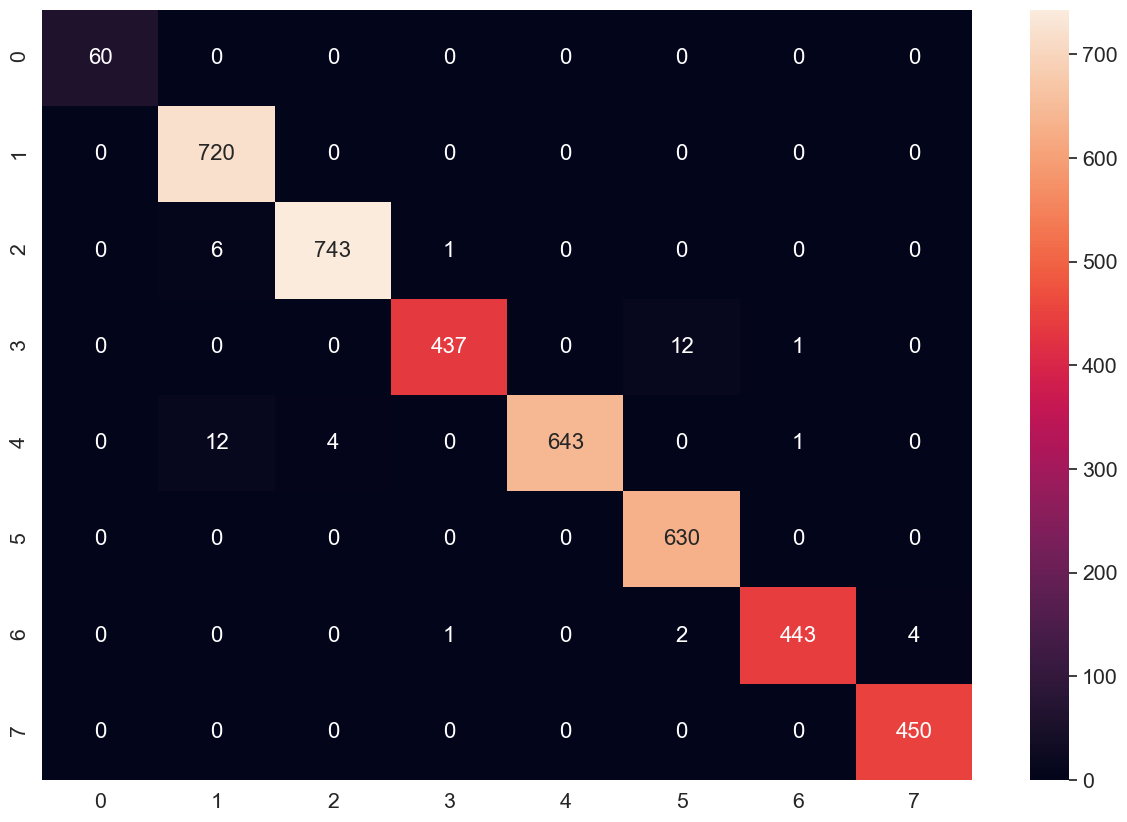

class:  0  total images:  60  % correct:  1.0
class:  1  total images:  720  % correct:  1.0
class:  2  total images:  750  % correct:  0.9906666666666667
class:  3  total images:  450  % correct:  0.9711111111111111
class:  4  total images:  660  % correct:  0.9742424242424242
class:  5  total images:  630  % correct:  1.0
class:  6  total images:  450  % correct:  0.9844444444444445
class:  7  total images:  450  % correct:  1.0


In [29]:
show_confusion_matrix(modelV3, test_set)